In [2]:
import os
from tqdm import tqdm
import yaml
from datasets.utils import parse_calibration, parse_poses, Quantize, SphereQuantize
import torch
import numpy as np
import matplotlib.pyplot as plt
import deep_point
from networks import backbone
from utils.rv_bev import converters

In [3]:
def VoxelMaxPool(pcds_feat, pcds_ind, output_size, scale_rate):
    voxel_feat = deep_point.VoxelMaxPool(
        pcds_feat=pcds_feat.contiguous().float(),
        pcds_ind=pcds_ind.contiguous(),
        output_size=output_size,
        scale_rate=scale_rate,
    ).to(pcds_feat.dtype)
    return voxel_feat

In [4]:
H_W_pairs = {
    "BEV" : (512, 512),
    "RV" : (64, 2048)
}

grid_2_point_scale_full = backbone.BilinearSample((1.0, 1.0))


import torch
import torch.nn.functional as F
from torch import nn
import math


converter_b2r = converters["BEV2RV"][512]
converter_r2b = converters["RV2BEV"][64]

print(converter_b2r.grid.min(), converter_b2r.grid.max())
print(converter_r2b.grid.min(), converter_r2b.grid.max())

tensor(-1.0000) tensor(1.0000)
tensor(-1.0635) tensor(0.9994)


In [5]:
def pretty_show(img):
    H, W = img[0][0].shape

    fig, ax = plt.subplots(figsize=(6, 6) if H == 512 else (20, 4))
    ax.imshow(img[0][0])
    plt.tight_layout()


def tensorize(np_arr):
    return torch.Tensor(np_arr)


def batchify(tensor):
    return tensor.unsqueeze(0)


def make_last_dim_1(tensor):
    return tensor.unsqueeze(-1)


def channelize(tensor):
    return tensor.unsqueeze(0)


def do_projection(value, coord, mode):
    rtn = VoxelMaxPool(
        pcds_feat=value,
        pcds_ind=coord,
        output_size=H_W_pairs[mode],
        scale_rate=(1.0, 1.0),
    )

    # print(value.shape, coord.shape, "->", rtn.shape)
    
    return rtn


def do_backprojection(value_img, coord):
    return grid_2_point_scale_full(value_img, coord)

In [6]:
with open("datasets/semantic-kitti.yaml", "r") as f:
    task_cfg = yaml.load(f)

<ipython-input-6-e42aee76061b>:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  task_cfg = yaml.load(f)


In [7]:
base = "/home/workspace/KITTI/dataset/sequences"
pred_root = "/home/workspace/work/GNU_MOS/val_results_GNUMOS/sequences"
save_root = "/home/workspace/work/GNU_MOS/val_results_GNUMOS_refined/sequences"

seq = "08"

print(f"▶ Sequence {seq}")
data_path = os.path.join(base, seq, "velodyne/")
calib_path = os.path.join(base, seq, "calib.txt")
pose_path = os.path.join(base, seq, "poses.txt")
pred_path = os.path.join(pred_root, seq, "predictions/")
save_path = os.path.join(save_root, seq, "predictions/")

files = sorted(os.listdir(data_path))  # N개의 bin path
poses_list = parse_poses(pose_path, parse_calibration(calib_path))  # N개의 4x4 Matrix

▶ Sequence 08


In [8]:
idx = 40
bin_path = os.path.join(data_path, files[idx])
pred_label_path = os.path.join(pred_path, "%06d.label" % idx)

xyzi = np.fromfile(bin_path, dtype=np.float32).reshape((-1, 4))
pred = torch.Tensor(np.fromfile(pred_label_path, dtype=np.int32).reshape((-1)) & 0xFFFF)

xyzi_quan = Quantize(
    xyzi,
    range_x=(-50.0, 50.0),
    range_y=(-50.0, 50.0),
    range_z=(-4.0, 2.0),
    size=(512, 512, 30),
)

sphere_quan = SphereQuantize(
    xyzi,
    phi_range=(-180.0, 180.0),
    theta_range=(-25.0, 3.0),
    r_range=(2.0, 50.0),
    size=(64, 2048, 48),
)

In [9]:
x_y_z_coord = torch.Tensor(xyzi_quan)  # N, 3
xy = x_y_z_coord[:, :2]  # N, 2
z = x_y_z_coord[:, 2]  # N
theta_phi_r_coord = torch.Tensor(sphere_quan)  #  N, 3
theta_phi = theta_phi_r_coord[:, :2]  # N, 2
r = theta_phi_r_coord[:, 2]  # N

xy = batchify(make_last_dim_1(xy))
z = batchify(make_last_dim_1(channelize(z)))
theta_phi = batchify(make_last_dim_1(theta_phi))
r = batchify(make_last_dim_1(channelize(r)))
prediction_point_raw = batchify(make_last_dim_1(channelize(pred)))

print(xy.shape, z.shape, theta_phi.shape, r.shape, prediction_point_raw.shape)

torch.Size([1, 122026, 2, 1]) torch.Size([1, 1, 122026, 1]) torch.Size([1, 122026, 2, 1]) torch.Size([1, 1, 122026, 1]) torch.Size([1, 1, 122026, 1])


## 232

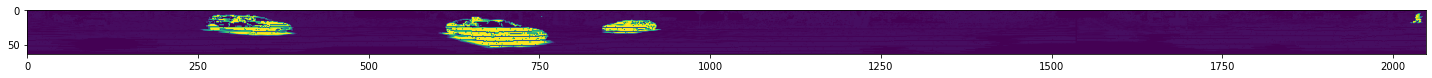

In [11]:
prediction_bev1 = do_projection(prediction_point_raw, xy, mode="BEV")
prediction_point = do_backprojection(prediction_bev1, xy)
prediction_rv1 = do_projection(prediction_point, theta_phi, mode="RV")
prediction_point = do_backprojection(prediction_rv1, theta_phi)
prediction_bev2 = do_projection(prediction_point, xy, mode="BEV")
pretty_show(prediction_rv1)

## 22

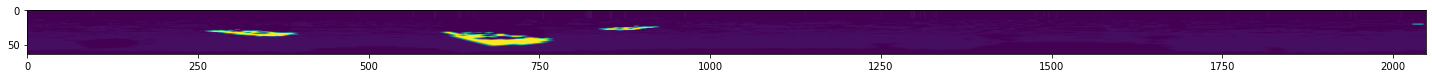

In [10]:
prediction_bev1 = do_projection(prediction_point_raw, xy, mode="BEV")
prediction_rv1 = converter_b2r(prediction_bev1)
prediction_bev2 = converter_r2b(prediction_rv1)
pretty_show(prediction_rv1)

## 232 2트

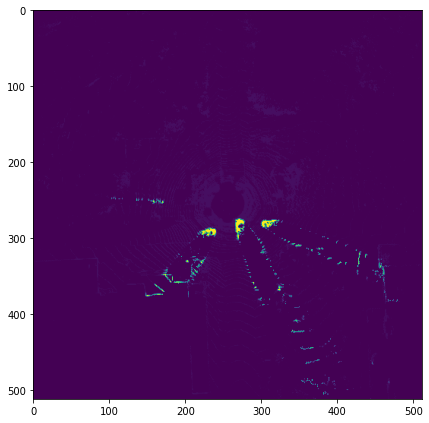

In [11]:
prediction_bev1 = do_projection(prediction_point_raw, xy, mode="BEV")


# 1트
prediction_point1 = do_backprojection(prediction_bev1, xy)
prediction_rv1 = do_projection(prediction_point1, theta_phi, mode="RV")
prediction_point2 = do_backprojection(prediction_rv1, theta_phi)
prediction_bev2 = do_projection(prediction_point2, xy, mode="BEV")

# 2트
prediction_point3 = do_backprojection(prediction_bev2, xy)
prediction_rv2 = do_projection(prediction_point3, theta_phi, mode="RV")
prediction_point4 = do_backprojection(prediction_rv2, theta_phi)
prediction_bev3 = do_projection(prediction_point4, xy, mode="BEV")

pretty_show(prediction_bev3)

## 22 2트

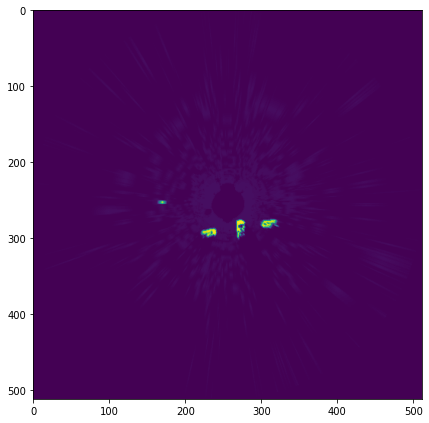

In [12]:
prediction_bev1 = do_projection(prediction_point_raw, xy, mode="BEV")


# 1트
prediction_rv1 = converter_b2r(prediction_bev1)
prediction_bev2 = converter_r2b(prediction_rv1)

# 2트
prediction_rv2 = converter_b2r(prediction_bev2)
prediction_bev3 = converter_r2b(prediction_rv2)
pretty_show(prediction_bev3)

tensor([  0,   1,   8,   9,  18,  24,  32,  33,  43,  48,  49,  50,  59,  65,
         83,  88,  89,  96,  99, 104, 105, 106, 112, 113, 114, 115, 121, 122,
        123, 128, 129, 130, 136, 137, 138, 139, 144, 145, 146, 147, 152, 153,
        154, 155, 160, 161, 162, 163, 168, 169, 170, 171, 176, 177, 178, 179,
        184, 185, 186, 187, 192, 193, 194, 195, 200, 201, 202, 203, 208, 209,
        210, 211, 216, 217, 218, 219, 224, 225, 226, 227, 232, 233, 234, 235,
        240, 241, 242, 243, 248, 249, 250, 251], dtype=torch.int32)


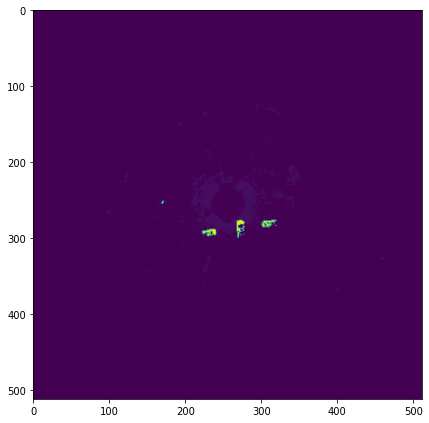

In [13]:
int_and = prediction_bev1.int() & prediction_bev3.int()
print(torch.unique(int_and))
pretty_show(int_and)